In [1]:
import cv2
import numpy as np
from math import sqrt, tan
import matplotlib.pyplot as plt

In [2]:
def imshow(*imgs: cv2.Mat):
    def helper(img: cv2.Mat):
        plt.axis('off')
        plt.grid(False)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        plt.show()
    for img in imgs:
        helper(img)

20 4


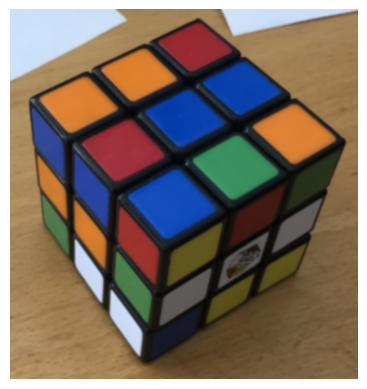

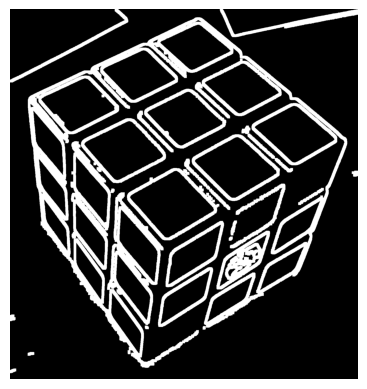

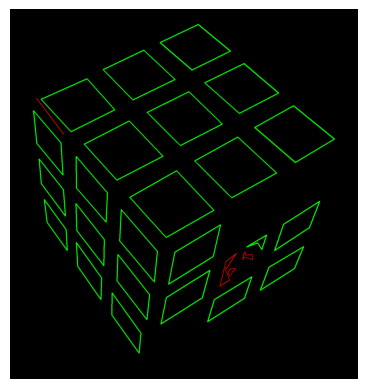

In [61]:
def filter_cubie_contours(img: cv2.Mat, contours: list[np.ndarray], approx: list[np.ndarray]) -> list[np.ndarray]:

    # filter erradic, non-quadrilateral contours
    proper_contours, proper_approx = [], []
    for cnt, appr in zip(contours, approx):

        # make sure the shape approximation is a quadrilateral
        if not len(appr) == 4:
            continue

        # make sure the approx isnt crazy different area-wise - consider removing this test
        cnt_area = cv2.contourArea(cnt, True)
        ratio = cnt_area / cv2.contourArea(appr, True)
        if min(ratio, 1/ratio) < 0.80:   # artitrary ratio thresold chosen by me
            continue

        # make sure the overlapping area isnt too bad
        overlap_reference = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(overlap_reference, [cnt], -1, (255, 255, 255), cv2.FILLED)
        cv2.drawContours(overlap_reference, [appr], -1, (0, 0, 0), cv2.FILLED)
        if (overlap_reference.sum() // 255) > (cnt_area // 5):
            continue

        proper_contours.append(cnt) 
        proper_approx.append(appr)

    return proper_approx

def get_cube_contours(img: cv2.Mat, show: bool = False) -> list[np.ndarray]:

    # computes some sizes
    reference_size = max(img.shape)
    blur_size = int(sqrt(reference_size) / 2)
    kernel_size = int(sqrt(reference_size) / 10)
    if show:
        print(blur_size, kernel_size)

    # image processing to get contours
    blur = cv2.GaussianBlur(img, (blur_size + int(blur_size % 2 == 0),) * 2, kernel_size)
    edges = cv2.Canny(blur, 20, 30)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size * 3,) * 2)
    dilated = cv2.dilate(edges, kernel)
    contours = sorted(cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea, reverse=True)
    large_contours = [*filter(lambda x: cv2.contourArea(x, True) > (img.shape[0] * img.shape[1]) // 5000, contours)]
    approx = [*map(lambda x: cv2.approxPolyDP(x, 0.03*cv2.arcLength(x, True), True), large_contours)]
    
    # filter the contours, show if needed
    filtered = filter_cubie_contours(img, large_contours, approx)
    if show:
        display_image = np.zeros_like(img)
        cv2.drawContours(display_image, approx, -1, (0, 0, 255), 2)
        cv2.drawContours(display_image, filtered, -1, (0, 255, 0), 3)
        imshow(blur, dilated, display_image)
    return filtered

_ = get_cube_contours(cv2.imread("./images/cube_ugly.png"), show=True)

In [ ]:
# determine which face everything is on
def get_ordered_face(squares: list[np.ndarray]):
    angle_to_squares = {}
    for appr in squares:
        _, _, _ = cv2.minAreaRect(appr)

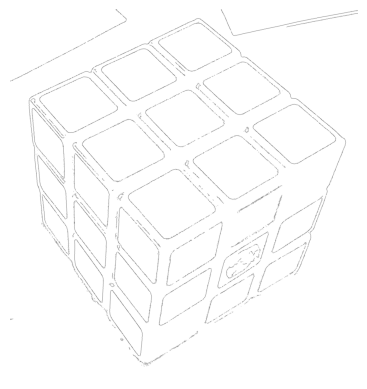

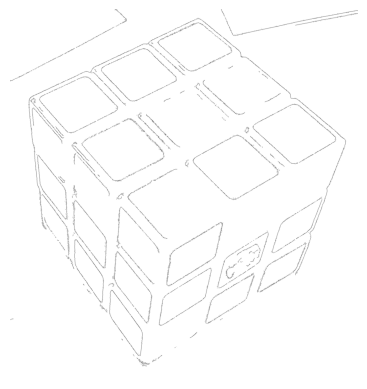

In [32]:
import time


img = cv2.imread("./images/cube_ugly.png")
blur = cv2.GaussianBlur(img, (21, 21), 5)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
imshow(*map(lambda x: cv2.bitwise_not(cv2.Canny(x, 20, 30)), [blur, gray]))

# start = time.perf_counter()
# edges = cv2.Canny(blur, 20, 30)
# end1 = time.perf_counter()
# thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 1)
# adjusted_thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
# end2 = time.perf_counter()
# imshow(cv2.bitwise_not(edges), adjusted_thresh)
# print(end1-start, end2-end1)